## Clip sjoin districts with original district file

In [1]:
import A1_provider_prep
import A2_analysis
import A3_other
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely.wkt
from calitp.sql import to_snakecase
from shared_utils import geography_utils, utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

### D4 Verizon

In [3]:
# Read in Verizon D4
v_d4 = gpd.read_parquet(
    f"{A1_provider_prep.GCS_FILE_PATH}Verizon_no_coverage_d4.parquet"
)

In [4]:
# Get routes
one_dist_routes, multi_dist_routes, all_routes = A3_other.find_multi_district_routes()

In [5]:
# multi_dist_routes_dissolved.drop(columns = ["geometry"])

In [6]:
# v_d4.plot()

In [7]:
# Open original district
districts = A1_provider_prep.get_districts()

In [8]:
# Get only d4
d4 = (districts.loc[districts.district == 4]).reset_index()

In [9]:
v_d4_clipped = gpd.clip(v_d4, d4, keep_geom_type=False)

<AxesSubplot:>

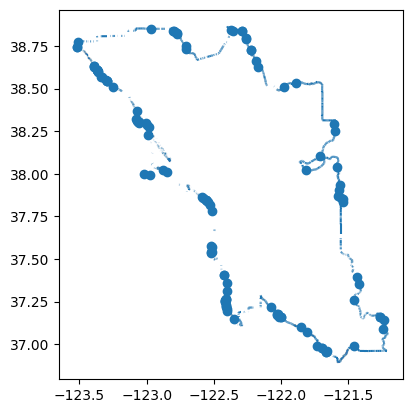

In [14]:
v_d4_clipped.plot()

In [10]:
"""n = v_d4_clipped.explore(
    color="red",
    width=800,
    height=400,
)"""

'n = v_d4_clipped.explore(\n    color="red",\n    width=800,\n    height=400,\n)'

In [11]:
# Clipped geometry
# n = d4.explore(m=n, legend=False)

In [53]:
# 10:19 to 10:20
routes_no_coverage = A2_analysis.comparison(
        all_routes, v_d4_clipped
    )

In [70]:
# routes_no_coverage.drop(columns = ["geometry"])

In [61]:
routes_no_coverage_list = routes_no_coverage.long_route_name.unique().tolist()

In [63]:
routes_no_coverage_og_geo = all_routes.loc[all_routes.long_route_name.isin(routes_no_coverage_list)]

In [64]:
routes_no_coverage_og_geo = routes_no_coverage_og_geo.explore(width=800,
    height=400, color= "red")

In [65]:
routes_no_coverage_og_geo = v_d4_clipped.explore(m=routes_no_coverage_og_geo,)

In [67]:
# routes_no_coverage_og_geo